# Our Bloom for Sequence Classification using Prompt Tuning

In this example, we showcase how Bloom model can be efficiently adapted in decentralized fashion. In particular, servers maintain the Bloom transformer, which is kept unchanged during adaptation, and learn only a few prefix tokens and a classification head.  

### Import all dependences and prepare the environment

In [2]:
%env CUDA_VISIBLE_DEVICES=7
%env OMP_NUM_THREADS=1
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

# General 
import torch
import pandas as pd
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

# Distributed
from src.bloom.model import BloomForSequenceClassification

# HF imports
import transformers
import datasets
from datasets import load_dataset, load_metric

# Visualization dependencies
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn-whitegrid')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

def print_params(model):
    for n, p in model.named_parameters():
        print(n, p.requires_grad, p.device)
        if p.requires_grad:
            print(p)

env: CUDA_VISIBLE_DEVICES=7
env: OMP_NUM_THREADS=1


### Config

In [3]:
MODEL_NAME='bigscience/bloom-6b3'

TASK='cola'
GLUE_TASKS = ["cola", "mnli", "mnli-mm", "mrpc", "qnli", "qqp", "rte", "sst2", "stsb", "wnli"]
max_length = 46

NUM_LABELS=2
DEVICE='cuda'
BATCH_SIZE=16

### Prepare the distributed Bloom model

In [4]:
model = BloomForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS
).to(DEVICE)
            
for name, p in model.named_parameters():
    if 'score' in name or 'prompt' in name:
        p.requires_grad = True
    else:
        p.requires_grad = False

model.transformer.intermediate_prompt_embeddings.weight.data.zero_()
print_params(model)

Some weights of BloomForSequenceClassification were not initialized from the model checkpoint at bigscience/bloom-6b3 and are newly initialized: ['prompt_embeddings.weight', 'intermediate_prompt_embeddings.weight', 'score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


transformer.word_embeddings.weight False cuda:0
transformer.word_embeddings_layernorm.weight False cuda:0
transformer.word_embeddings_layernorm.bias False cuda:0
transformer.h.0.input_layernorm.weight False cuda:0
transformer.h.0.input_layernorm.bias False cuda:0
transformer.h.0.self_attention.query_key_value.weight False cuda:0
transformer.h.0.self_attention.query_key_value.bias False cuda:0
transformer.h.0.self_attention.dense.weight False cuda:0
transformer.h.0.self_attention.dense.bias False cuda:0
transformer.h.0.post_attention_layernorm.weight False cuda:0
transformer.h.0.post_attention_layernorm.bias False cuda:0
transformer.h.0.mlp.dense_h_to_4h.weight False cuda:0
transformer.h.0.mlp.dense_h_to_4h.bias False cuda:0
transformer.h.0.mlp.dense_4h_to_h.weight False cuda:0
transformer.h.0.mlp.dense_4h_to_h.bias False cuda:0
transformer.h.1.input_layernorm.weight False cuda:0
transformer.h.1.input_layernorm.bias False cuda:0
transformer.h.1.self_attention.query_key_value.weight Fals

## Dataset

This examples operates on SST-2 dataset for binary sentence classification.

In [5]:
import random
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [6]:
dataset = load_dataset("glue", TASK)
metric = load_metric('glue', TASK)

Jul 26 05:43:11.007 [WARN] [datasets.builder.download_and_prepare:641] Reusing dataset glue (/home/dbaranchuk/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
# task_to_keys = {
#     "cola": ("sentence", None),
#     "mnli": ("premise", "hypothesis"),
#     "mnli-mm": ("premise", "hypothesis"),
#     "mrpc": ("sentence1", "sentence2"),
#     "qnli": ("question", "sentence"),
#     "qqp": ("question1", "question2"),
#     "rte": ("sentence1", "sentence2"),
#     "sst2": ("sentence", None),
#     "stsb": ("sentence1", "sentence2"),
#     "wnli": ("sentence1", "sentence2"),
# }

# sentence1_key, sentence2_key = task_to_keys[task]
# if sentence2_key is None:
#     print(f"Sentence: {dataset['train'][0][sentence1_key]}")
# else:
#     print(f"Sentence 1: {dataset['train'][0][sentence1_key]}")
#     print(f"Sentence 2: {dataset['train'][0][sentence2_key]}")

In [8]:
from transformers import BloomTokenizerFast

def preprocess_function(examples):
    return tokenizer(examples["sentence"], padding='max_length', truncation=False)

tokenizer = BloomTokenizerFast.from_pretrained(MODEL_NAME)
tokenizer.padding_side = 'right'

In [9]:
tokenizer.model_max_length = 46
tokenized_datasets = dataset.map(preprocess_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["sentence", "idx", "attention_mask"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

train_dataset = tokenized_datasets["train"].shuffle(seed=42)
valid_dataset = tokenized_datasets["validation"].shuffle(seed=42)
test_dataset = tokenized_datasets["test"].shuffle(seed=42)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Jul 26 05:43:16.698 [WARN] [datasets.fingerprint.update_fingerprint:328] Parameter 'function'=<function preprocess_function at 0x7f8b1b499280> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

### Create optimizer and scheduler

In [10]:
from transformers import get_scheduler
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=1e-3)

num_epochs = 40
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

### Eval utils

In [11]:
moving_average = lambda x, **kw: pd.Series(x).ewm(**kw).mean().values

def eval_metrics(model, dataloader, device='cpu'):
    model.eval()
    for batch in dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        metric.add_batch(predictions=predictions, references=batch["labels"])
    model.train()
    return metric.compute()

### Training loop

  0%|          | 0/21400 [00:00<?, ?it/s]

Iteration: 535


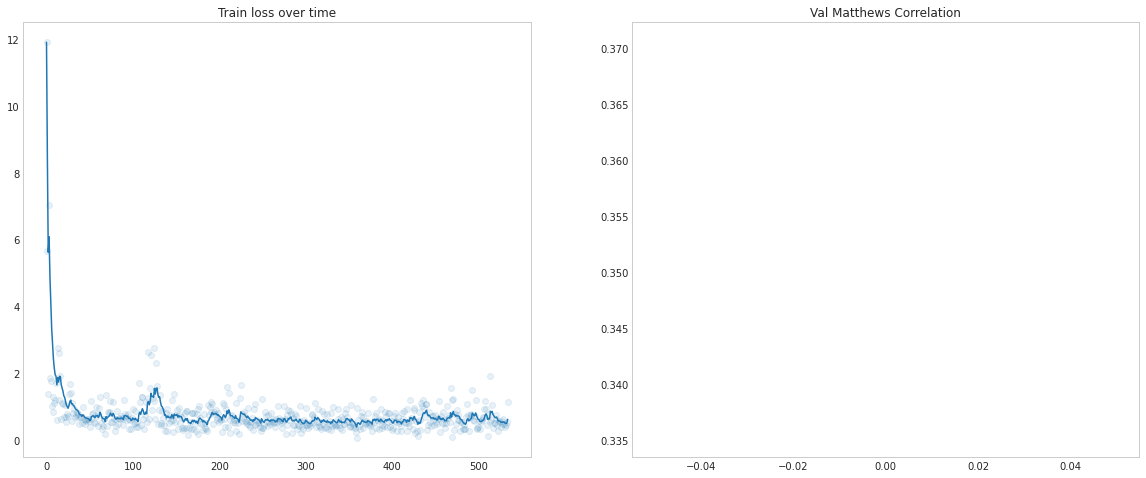

Val Matthews Correlations:  [0.35291635752703904]
Iteration: 1070


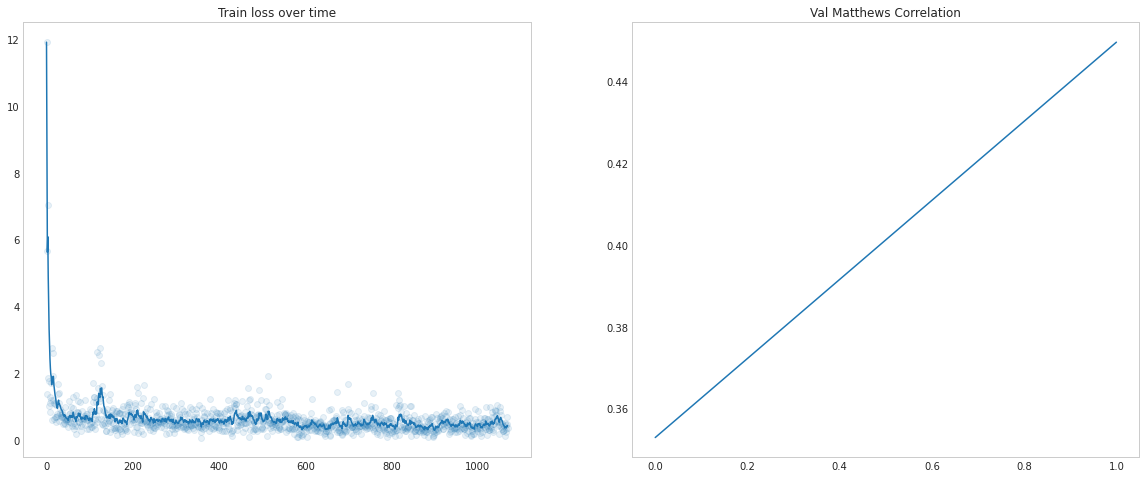

Val Matthews Correlations:  [0.35291635752703904, 0.44962496864677076]
Iteration: 1605


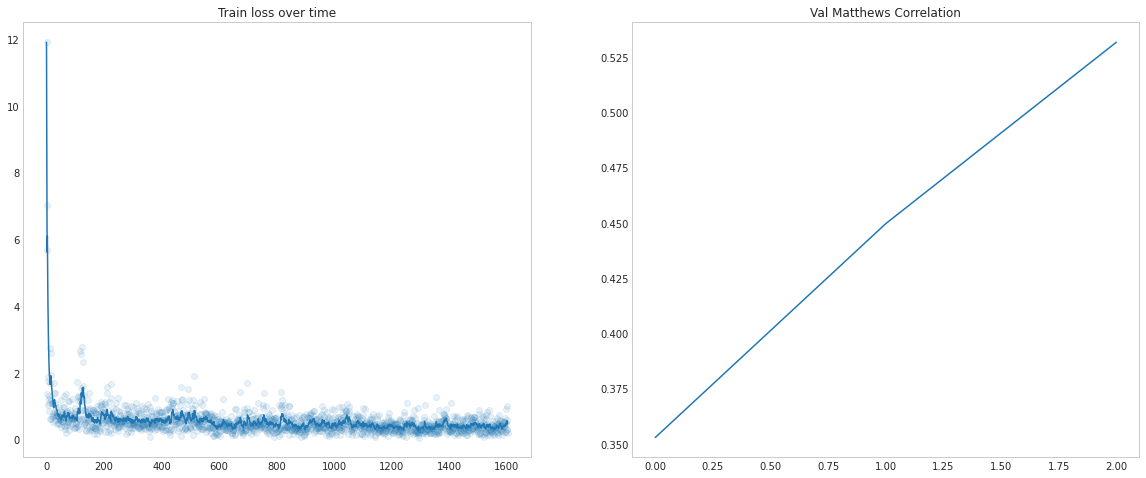

Val Matthews Correlations:  [0.35291635752703904, 0.44962496864677076, 0.5316339899555328]


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration: 6955


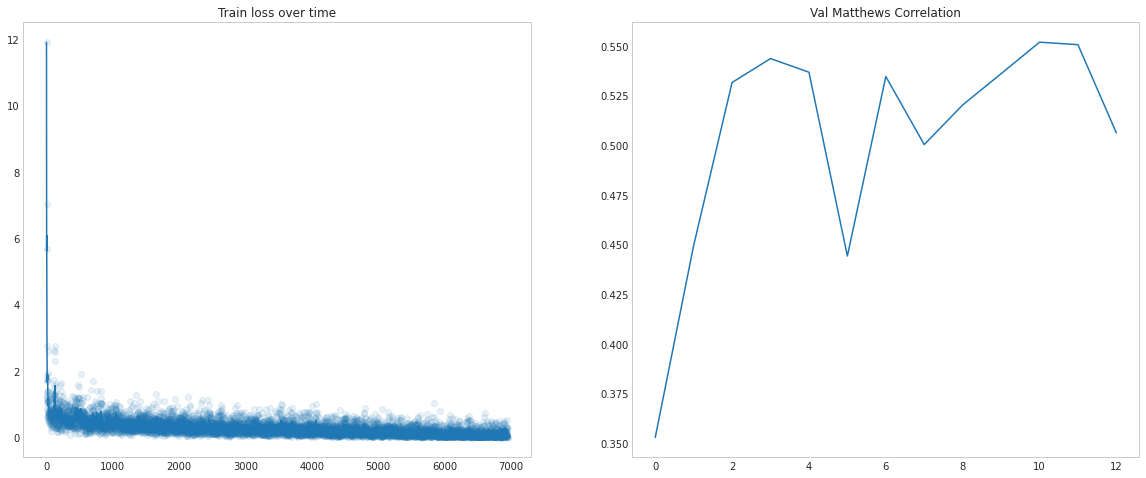

Val Matthews Correlations:  [0.35291635752703904, 0.44962496864677076, 0.5316339899555328, 0.5436664175123365, 0.5367938458903196, 0.44428318348755624, 0.5346350864033648, 0.5003634450667074, 0.5203184005786298, 0.5360539568819722, 0.551912586443, 0.5506572461908373, 0.5062337742899393]
Iteration: 7490


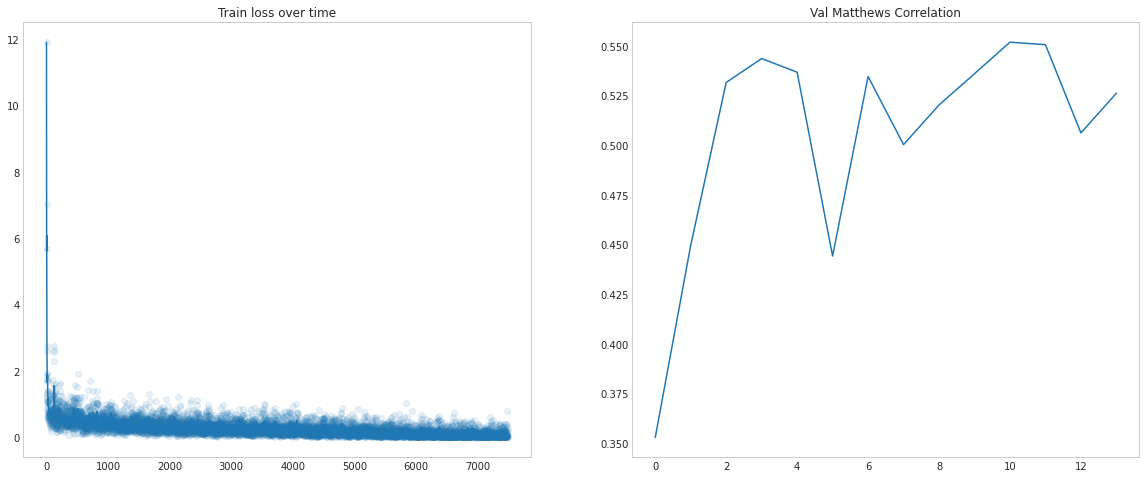

Val Matthews Correlations:  [0.35291635752703904, 0.44962496864677076, 0.5316339899555328, 0.5436664175123365, 0.5367938458903196, 0.44428318348755624, 0.5346350864033648, 0.5003634450667074, 0.5203184005786298, 0.5360539568819722, 0.551912586443, 0.5506572461908373, 0.5062337742899393, 0.5262151184994416]
Iteration: 8025


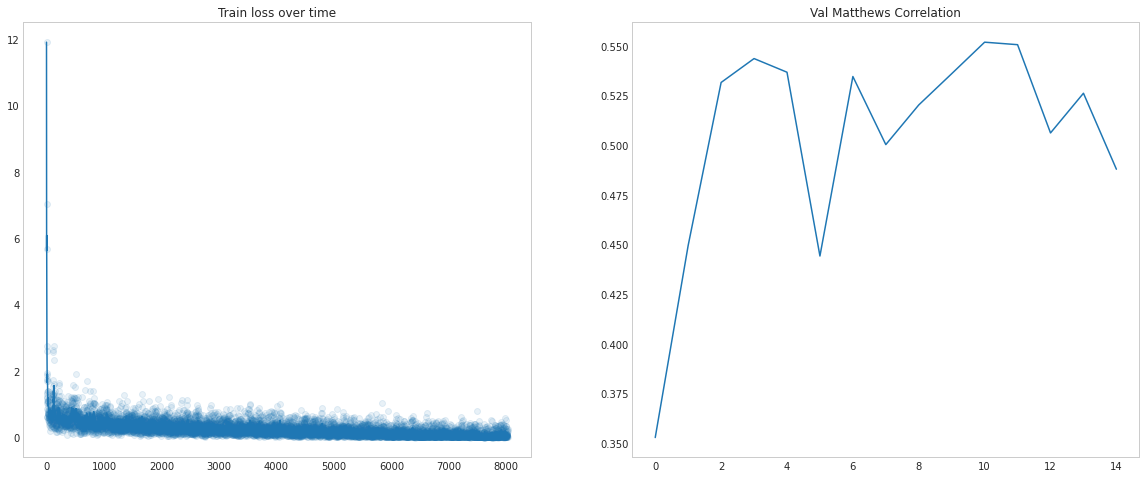

Val Matthews Correlations:  [0.35291635752703904, 0.44962496864677076, 0.5316339899555328, 0.5436664175123365, 0.5367938458903196, 0.44428318348755624, 0.5346350864033648, 0.5003634450667074, 0.5203184005786298, 0.5360539568819722, 0.551912586443, 0.5506572461908373, 0.5062337742899393, 0.5262151184994416, 0.48797643700766546]


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration: 13375


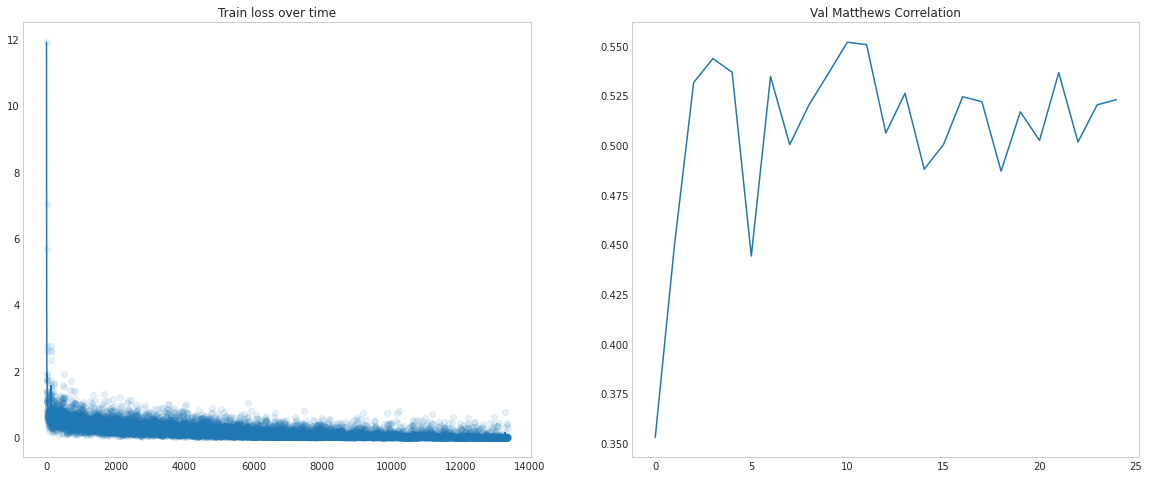

Val Matthews Correlations:  [0.35291635752703904, 0.44962496864677076, 0.5316339899555328, 0.5436664175123365, 0.5367938458903196, 0.44428318348755624, 0.5346350864033648, 0.5003634450667074, 0.5203184005786298, 0.5360539568819722, 0.551912586443, 0.5506572461908373, 0.5062337742899393, 0.5262151184994416, 0.48797643700766546, 0.500349204926843, 0.524468016377014, 0.5219552527235838, 0.48698144266663124, 0.5168530090749146, 0.5024595293214101, 0.5365928786683274, 0.5016646253174374, 0.5203811415338604, 0.5229748811318968]
Iteration: 13910


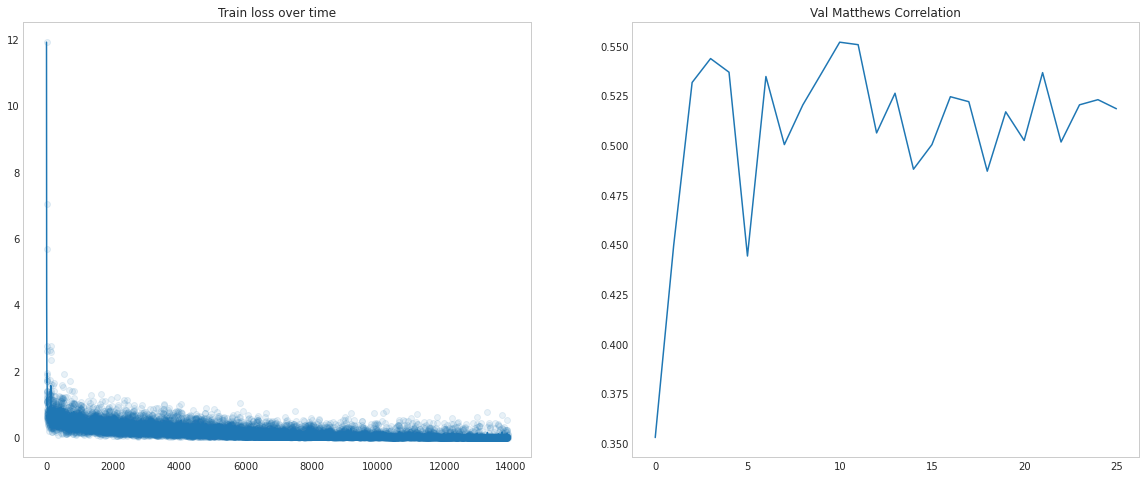

Val Matthews Correlations:  [0.35291635752703904, 0.44962496864677076, 0.5316339899555328, 0.5436664175123365, 0.5367938458903196, 0.44428318348755624, 0.5346350864033648, 0.5003634450667074, 0.5203184005786298, 0.5360539568819722, 0.551912586443, 0.5506572461908373, 0.5062337742899393, 0.5262151184994416, 0.48797643700766546, 0.500349204926843, 0.524468016377014, 0.5219552527235838, 0.48698144266663124, 0.5168530090749146, 0.5024595293214101, 0.5365928786683274, 0.5016646253174374, 0.5203811415338604, 0.5229748811318968, 0.5184089066052082]
Iteration: 14445


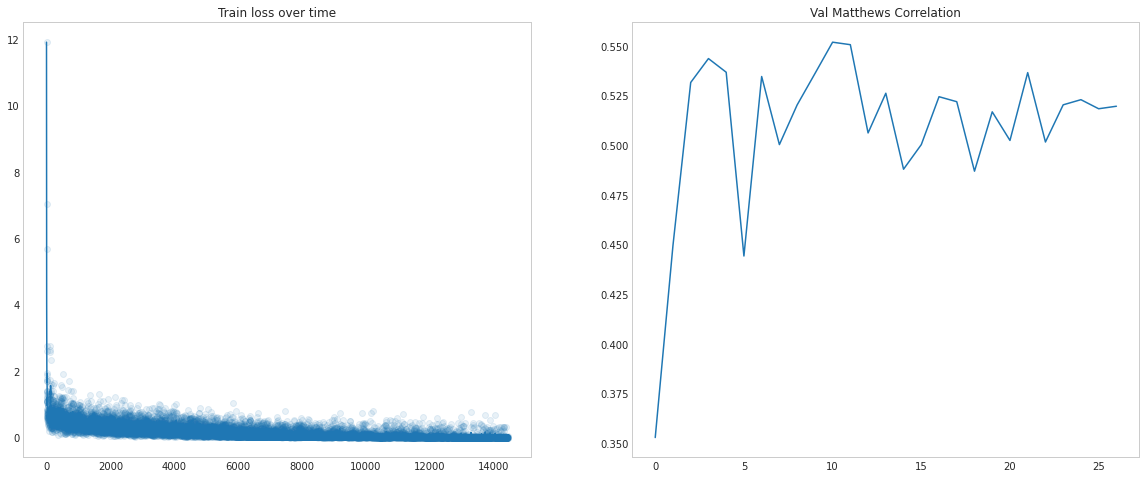

Val Matthews Correlations:  [0.35291635752703904, 0.44962496864677076, 0.5316339899555328, 0.5436664175123365, 0.5367938458903196, 0.44428318348755624, 0.5346350864033648, 0.5003634450667074, 0.5203184005786298, 0.5360539568819722, 0.551912586443, 0.5506572461908373, 0.5062337742899393, 0.5262151184994416, 0.48797643700766546, 0.500349204926843, 0.524468016377014, 0.5219552527235838, 0.48698144266663124, 0.5168530090749146, 0.5024595293214101, 0.5365928786683274, 0.5016646253174374, 0.5203811415338604, 0.5229748811318968, 0.5184089066052082, 0.5196718863326]


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration: 19260


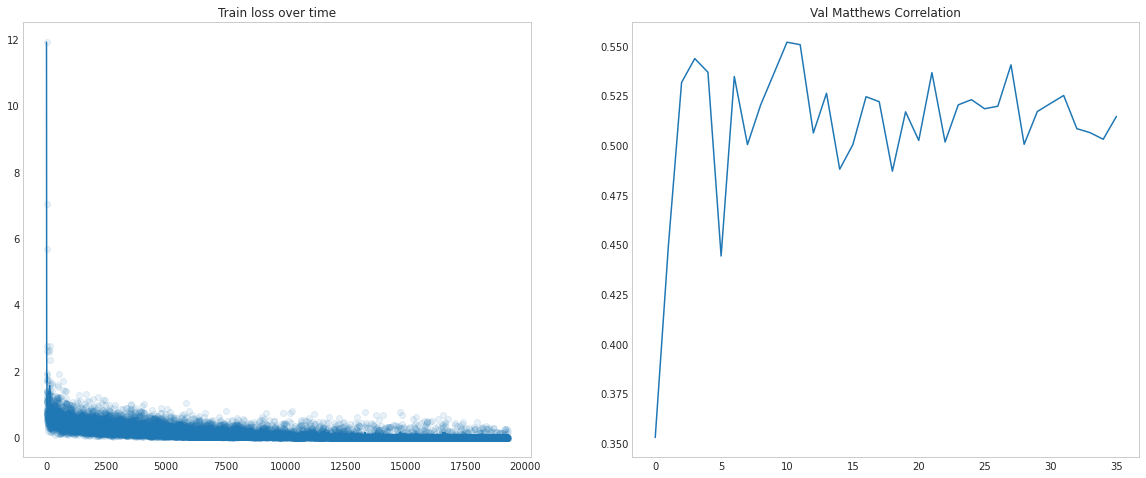

Val Matthews Correlations:  [0.35291635752703904, 0.44962496864677076, 0.5316339899555328, 0.5436664175123365, 0.5367938458903196, 0.44428318348755624, 0.5346350864033648, 0.5003634450667074, 0.5203184005786298, 0.5360539568819722, 0.551912586443, 0.5506572461908373, 0.5062337742899393, 0.5262151184994416, 0.48797643700766546, 0.500349204926843, 0.524468016377014, 0.5219552527235838, 0.48698144266663124, 0.5168530090749146, 0.5024595293214101, 0.5365928786683274, 0.5016646253174374, 0.5203811415338604, 0.5229748811318968, 0.5184089066052082, 0.5196718863326, 0.5405125165398501, 0.5005002695784156, 0.517019830122638, 0.5210800592819055, 0.5250950842810813, 0.5083797346306002, 0.5063831757470589, 0.5030428367546121, 0.5145416021693702]
Iteration: 19795


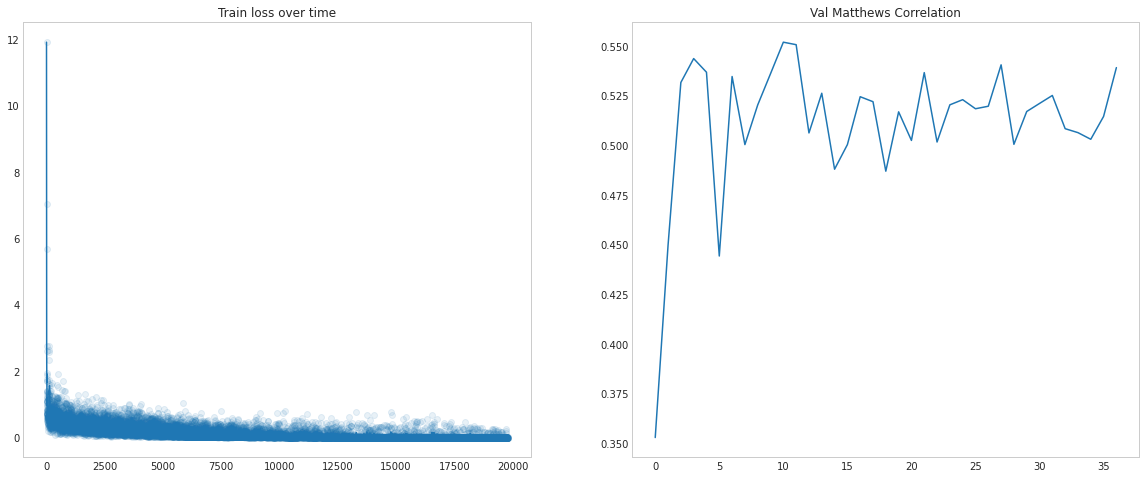

Val Matthews Correlations:  [0.35291635752703904, 0.44962496864677076, 0.5316339899555328, 0.5436664175123365, 0.5367938458903196, 0.44428318348755624, 0.5346350864033648, 0.5003634450667074, 0.5203184005786298, 0.5360539568819722, 0.551912586443, 0.5506572461908373, 0.5062337742899393, 0.5262151184994416, 0.48797643700766546, 0.500349204926843, 0.524468016377014, 0.5219552527235838, 0.48698144266663124, 0.5168530090749146, 0.5024595293214101, 0.5365928786683274, 0.5016646253174374, 0.5203811415338604, 0.5229748811318968, 0.5184089066052082, 0.5196718863326, 0.5405125165398501, 0.5005002695784156, 0.517019830122638, 0.5210800592819055, 0.5250950842810813, 0.5083797346306002, 0.5063831757470589, 0.5030428367546121, 0.5145416021693702, 0.5391186766943304]
Iteration: 20330


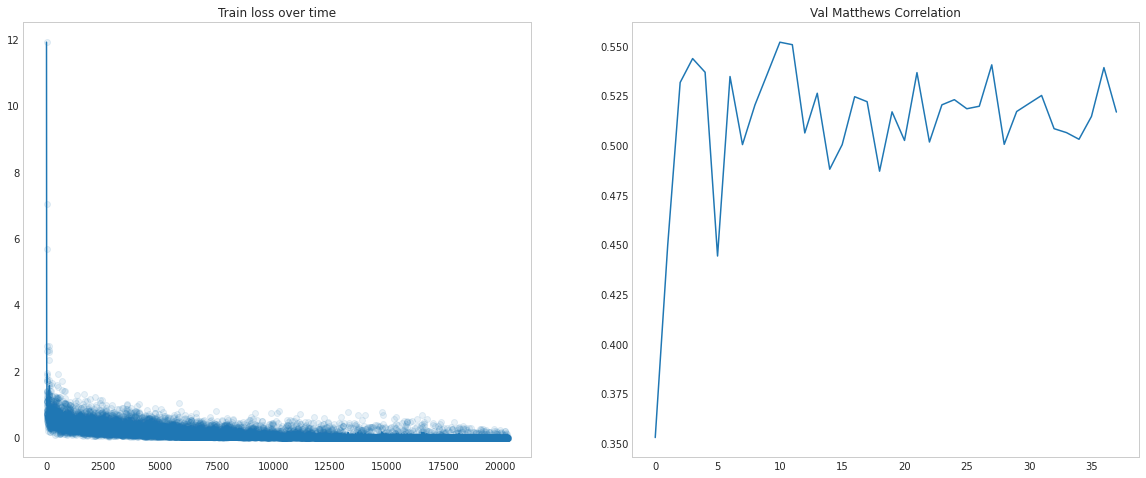

Val Matthews Correlations:  [0.35291635752703904, 0.44962496864677076, 0.5316339899555328, 0.5436664175123365, 0.5367938458903196, 0.44428318348755624, 0.5346350864033648, 0.5003634450667074, 0.5203184005786298, 0.5360539568819722, 0.551912586443, 0.5506572461908373, 0.5062337742899393, 0.5262151184994416, 0.48797643700766546, 0.500349204926843, 0.524468016377014, 0.5219552527235838, 0.48698144266663124, 0.5168530090749146, 0.5024595293214101, 0.5365928786683274, 0.5016646253174374, 0.5203811415338604, 0.5229748811318968, 0.5184089066052082, 0.5196718863326, 0.5405125165398501, 0.5005002695784156, 0.517019830122638, 0.5210800592819055, 0.5250950842810813, 0.5083797346306002, 0.5063831757470589, 0.5030428367546121, 0.5145416021693702, 0.5391186766943304, 0.5167437962981968]


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [12]:
progress_bar = tqdm(range(num_training_steps))

loss_history = []
accuracy_history = []

for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        
        model.train()
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        loss_history.append(loss.item())

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        
    print(f'Iteration: {progress_bar.n}')
    plt.figure(figsize=[20, 8])
    plt.subplot(1,2,1)
    plt.title('Train loss over time', fontsize=12); plt.grid();
    plt.plot(moving_average(loss_history, span=10))
    plt.scatter(range(len(loss_history)), loss_history, alpha=0.1)

    met = eval_metrics(model, valid_dataloader, device=DEVICE)
    accuracy_history.append(met['matthews_correlation'])

    plt.subplot(1,2,2)
    plt.title('Val Matthews Correlation', fontsize=12); plt.grid();
    plt.plot(accuracy_history)
    plt.show()
    print('Val Matthews Correlations: ', [round(elem, 3) for elem in accuracy_history])

In [14]:
sum(loss_history[-1000:]) / 1000

0.20686145172361284